In [49]:
!pip install torchbearer

import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

You should consider upgrading via the '/Users/ahmadkida/Documents/SCHOOL/Fourth Year/Group Project/additional (4)/pyworking/bin/python -m pip install --upgrade pip' command.


In [50]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

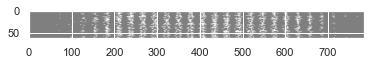

In [52]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [53]:
class FCNClass(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass, self).__init__()
        
        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(), 
                        nn.Dropout(p=0.5)
        )
        
        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(), 
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        
        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(), 
                        nn.Dropout(p=0.5)
        )
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        output   = self.output(midLevel)
        return output

In [54]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [55]:
model = FCNClass().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [56]:

loss_history = []
epochs = []
train_loss = torch.zeros(num_epochs)
n_total_steps = len(train_loader)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())
        epochs.append(epoch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    train_loss[epoch] = running_loss
    loss_history.append(loss.item())
    epochs.append(epoch)

    #step the learning rate scheduler
    scheduler.step()

    if (epoch+1) % 30 == 0:
        plotLosses(epochs, loss_history, 'loss graph for cnn')

print("--- %s seconds ---" % (time.time() - start_time))

print('Finished Training')
PATH = './FCN.pth'
torch.save(model.state_dict(), PATH)


'\n\nloss_history = []\nepochs = []\ntrain_loss = torch.zeros(num_epochs)\nn_total_steps = len(train_loader)\nscheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)\nstart_time = time.time()\nfor epoch in range(num_epochs):\n    running_loss = 0\n    for i, (images, labels) in enumerate(train_loader):\n        images = images.to(device)\n        labels = labels.to(device)\n\n        # Forward pass\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n        loss_history.append(loss.item())\n        epochs.append(epoch)\n\n        # Backward and optimize\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        #step the learning rate scheduler\n        scheduler.step()\n\n\n        running_loss += loss.item()\n        if (i+1) % 200 == 0:\n            print (f\'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}\')\n\n    train_loss[epoch] = running_loss\n  

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')